# LLM - Detect AI Generated Text
# (CNN) Convolution Neural Network

## Import

In [1]:
import math
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample
from sklearn.metrics import roc_curve ,precision_recall_curve,auc,confusion_matrix,ConfusionMatrixDisplay
import keras


2024-01-10 18:34:06.048604: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-10 18:34:06.048642: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-10 18:34:06.079067: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-10 18:34:06.144564: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-10 18:34:07.194468: W tensorflow/compiler/tf2

In [2]:
pre_processed_data=pd.read_csv("../data/pre_process/doc2vec.csv")
pre_processed_data

/tmp/ipykernel_65377/808020257.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  pre_processed_data=pd.read_csv("../data/pre_process/doc2vec.csv")


,id,prompt_id,generated,0,1,2,3,4,5,6,...,96,97,98,99,normalized_norm,token_num,sent_num,punct_sym,apostrof_sym,unk_num
0,0059830c,0,0,-0.017544,-0.036879,0.001294,0.088538,0.069350,0.051428,-0.062259,...,-0.047804,-0.018791,0.057600,-0.026335,0.320077,0.003912,0.004492,0.005521,0.000000,0
1,005db917,0,0,0.008965,-0.004766,-0.023785,0.097447,0.029138,-0.096148,0.092494,...,-0.066157,0.123343,0.014478,-0.069293,0.277780,0.003912,0.004866,0.004616,0.004868,0
2,008f63e3,0,0,-0.220178,-0.039477,0.066857,0.102177,0.110360,-0.008355,-0.024121,...,-0.125095,-0.001598,-0.070979,-0.084900,0.360477,0.003912,0.008983,0.006969,0.002434,0
3,00940276,0,0,-0.081973,-0.113168,0.069693,0.073340,0.049455,-0.018525,-0.056701,...,-0.128309,-0.047691,-0.042124,-0.131834,0.385377,0.003912,0.006550,0.007240,0.000000,0
4,00c39458,0,0,-0.066073,-0.107501,0.080051,0.070197,0.001512,-0.008640,-0.078753,...,-0.133187,0.048298,0.002570,-0.093981,0.461385,0.003912,0.008983,0.007602,0.002434,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65349,65525,1,1,-0.012233,-0.081156,0.006432,-0.040683,0.126697,0.022267,-0.044591,...,0.134248,0.054473,0.059105,0.027512,0.173256,0.003912,0.003369,0.003258,0.000000,0
65350,65526,1,1,-0.022889,-0.085193,-0.074535,-0.023842,0.014821,0.013985,-0.106470,...,-0.018349,-0.016564,-0.048282,0.018813,0.239976,0.003912,0.004305,0.003711,0.000000,0
65351,65527,1,1,-0.105067,-0.008494,-0.145032,-0.016242,0.005580,-0.010481,-0.065304,...,-0.017710,-0.075679,-0.019108,0.010756,0.215661,0.003912,0.003743,0.003530,0.000000,0
65352,65528,1,1,0.082928,0.002637,0.011657,-0.045298,0.041979,0.068132,0.062303,...,0.058296,0.081840,0.019200,-0.090430,0.206971,0.003912,0.003369,0.003168,0.000000,0


## Random Downsampling

In [3]:
def downsampling(X_train,y_train,rand_state,ratio):
    # Concatenate X_train and y_train for ease of downsampling
    train_data = pd.concat([X_train, y_train], axis=1)

    # Identify the class with the majority of instances
    majority_class = train_data[y_train.name].value_counts().idxmax()

    # Separate instances of each class
    majority_class_data = train_data[train_data[y_train.name] == majority_class]
    minority_class_data = train_data[train_data[y_train.name] != majority_class]


    currRatio = len(majority_class_data) / len(minority_class_data)
    if(currRatio<=ratio):
        raise ValueError(f"El ratio de entrada debe ser menor al ratio actual.r={currRatio}")


    # Downsample the majority class to match the number of instances in the minority class
    downsampled_majority_class_data = resample(
        majority_class_data,
        replace=False,
        n_samples=math.floor(ratio*len(minority_class_data)),
        random_state=rand_state
    )

    # Combine the downsampled majority class with the minority class
    downsampled_train_data = pd.concat([downsampled_majority_class_data, minority_class_data])

    # Shuffle the data to avoid any order-based patterns
    downsampled_train_data = downsampled_train_data.sample(frac=1, random_state=rand_state)

    # Separate X_train and y_train after downsampling
    X_train_downsampled = downsampled_train_data.drop(columns=[y_train.name])
    y_train_downsampled = downsampled_train_data[y_train.name]

    return X_train_downsampled, y_train_downsampled

## ROC AUC curve

In [4]:
def ROCcurves(model,x_val,y_val):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    
    y_pred = model.predict(x_val).ravel()
    fpr, tpr , _ = roc_curve(y_val,  y_pred)
    auc_ss = auc(fpr,tpr)
    precision, recall, _ = precision_recall_curve(y_val,  y_pred)
    auc_pr = auc(recall, precision)

    # Primer subgráfico
    axs[0].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='AUC = 0.50')
    axs[0].plot(fpr,tpr, label='ROC curve', color='blue')
    axs[0].set_title(f'ROC curve = {round(auc_ss,3)}')
    axs[0].set_xlabel('FalsePositiveRate')
    axs[0].set_ylabel('TruePositiveRate')
    axs[0].legend()
    # Segundo subgráfico
    axs[1].plot([0, 1], [0,0], color='gray', lw=1, linestyle='--', label='AUC = 0.0')
    axs[1].plot(recall, precision, label='ROC-RP curve', color='orange')
    axs[1].set_title(f'ROC-RP curve = {round(auc_pr,3)}')
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precision')
    axs[1].legend()
    plt.show()



## Arquitecture

In [15]:
input = keras.Input(shape=(pre_processed_data.shape[1]-2))
x = keras.layers.Reshape(target_shape=(1,pre_processed_data.shape[1]-2))(input)
x = keras.layers.Convolution1D(100,kernel_size=10,padding="same",strides=1,activation="relu")(x)
x = keras.layers.Convolution1D(100,kernel_size=20,padding="same",strides=1,activation="relu")(x)
x = keras.layers.Convolution1D(100,kernel_size=40,padding="same",strides=1,activation="relu")(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(100,activation="relu")(x)
x = keras.layers.Dense(50,activation="relu")(x)
x = keras.layers.Dense(10,activation="relu")(x)
output = keras.layers.Dense(1,activation="sigmoid")(x)

model = keras.Model(input,output)

model.compile(optimizer='adam',
               loss=keras.losses.BinaryCrossentropy(),
               metrics=[keras.metrics.AUC()])

## Training

In [16]:
rand_state= random.randint(0,1000)
#NN training with 10-fold cross-validation stratified with random under-sampling technic for imbalanced data
X = pre_processed_data.drop(["id","generated"],axis=1)
Y = pre_processed_data["generated"]
folds = StratifiedKFold(10,shuffle=True,random_state=rand_state)
for fold, (train_index, val_index) in enumerate(folds.split(X,Y)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = Y.iloc[train_index], Y.iloc[val_index]

    X_train_dwns, y_train_dwns = downsampling(X_train,y_train,rand_state,ratio=1.3)

    #print(f"Fold {fold + 1}: Train {len(train_index)} samples, Validation {len(val_index)} samples")
    #print(f"TRAIN:({y_train[y_train==0].size}:{y_train[y_train==1].size})")
    print(f"DOWNSAMPLED:({y_train_dwns[y_train_dwns==0].size}:{y_train_dwns[y_train_dwns==1].size})")
    #print(f"VAL:({y_val[y_val==0].size}:{y_val[y_val==1].size})")
    model.fit(X_train_dwns,
                y_train_dwns,
                validation_data=(X_val,y_val),
                batch_size=1000,
                epochs=5)

DOWNSAMPLED:(24633:32022)
Epoch 1/5
57/57 [==============================] - 5s 73ms/step - loss: 0.6692 - auc_1: 0.5854 - val_loss: 0.6048 - val_auc_1: 0.7795
Epoch 2/5
57/57 [==============================] - 4s 70ms/step - loss: 0.5683 - auc_1: 0.7772 - val_loss: 0.5166 - val_auc_1: 0.8172
Epoch 3/5
57/57 [==============================] - 4s 69ms/step - loss: 0.4994 - auc_1: 0.8315 - val_loss: 0.4744 - val_auc_1: 0.8488
Epoch 4/5
57/57 [==============================] - 4s 74ms/step - loss: 0.4551 - auc_1: 0.8636 - val_loss: 0.4360 - val_auc_1: 0.8763
Epoch 5/5
57/57 [==============================] - 4s 71ms/step - loss: 0.4119 - auc_1: 0.8906 - val_loss: 0.4219 - val_auc_1: 0.9014
DOWNSAMPLED:(24634:32024)
Epoch 1/5
57/57 [==============================] - 4s 69ms/step - loss: 0.3883 - auc_1: 0.9037 - val_loss: 0.3510 - val_auc_1: 0.9246
Epoch 2/5
57/57 [==============================] - 4s 68ms/step - loss: 0.3565 - auc_1: 0.9200 - val_loss: 0.3509 - val_auc_1: 0.9292
Epoch 3/5


2043/2043 [==============================] - 4s 2ms/step


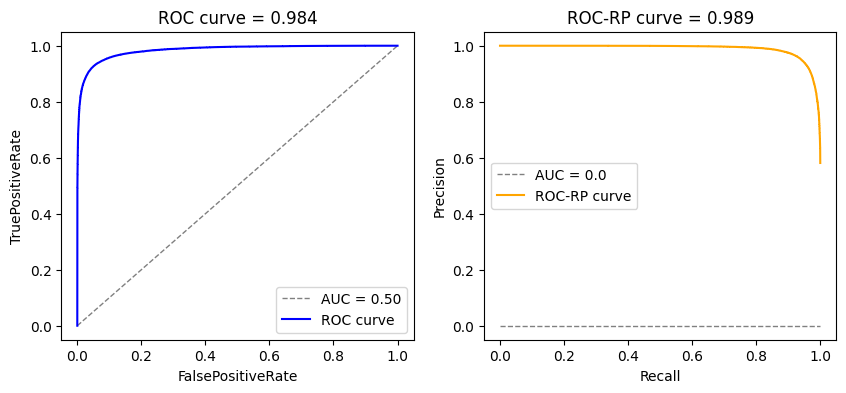

In [17]:
ROCcurves(model,X,Y)

2043/2043 [==============================] - 4s 2ms/step


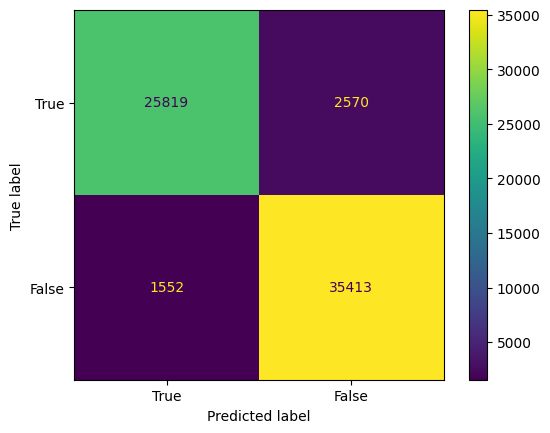

In [18]:
pred = list(map(lambda pred : 1 if pred > 0.5 else 0,model.predict(x=X)))
display = ConfusionMatrixDisplay(confusion_matrix(pred,Y),display_labels=["True","False"])
display.plot()

In [19]:
model.predict(x=pd.DataFrame(X.iloc[1385]).transpose())

1/1 [==============================] - 0s 17ms/step


array([[0.99995637]], dtype=float32)

## Save model weights

In [20]:

model.save("../data/CNN/weights.h5")

/home/mrtc101/Desktop/ciencias de la computacion/Cursado/4.2Inteligencia Artificial 2/Final/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
